Loading train/test splits...
X_train shape: (3392, 15)
X_test shape: (848, 15)

Setting up Grid Search for Lasso Logistic Regression with sub-sampling...
Running Grid Search with sub-sampling...
Fitting 5 folds for each of 52 candidates, totalling 260 fits

Best Parameters (sub-sampling):
{'C': 0.05, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validated F1-Score: 0.6580

Test Set Results (threshold = 0.5):
Accuracy: 0.6616
Classification Report (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.92      0.66      0.77       719
           1       0.26      0.67      0.38       129

    accuracy                           0.66       848
   macro avg       0.59      0.67      0.57       848
weighted avg       0.82      0.66      0.71       848


🔍 Optimizing threshold for best F1 score...
✅ Optimaler Threshold: 0.49
✅ F1-Score bei optimalem Threshold: 0.3864


/opt/anaconda3/envs/thesis_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


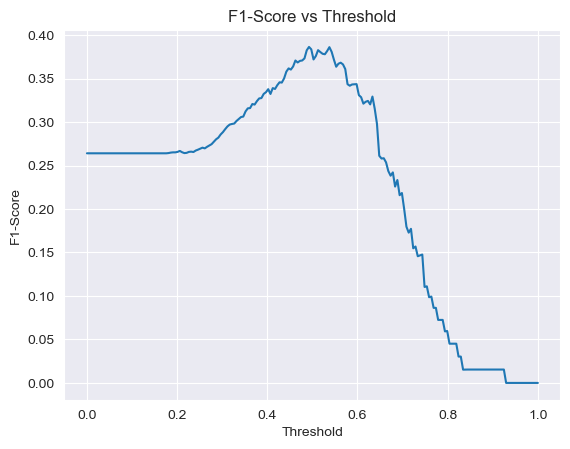


Test Set Results (optimierter Threshold):
Accuracy: 0.6592
Classification Report (optimierter Threshold):
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       719
           1       0.27      0.71      0.39       129

    accuracy                           0.66       848
   macro avg       0.60      0.68      0.58       848
weighted avg       0.82      0.66      0.71       848



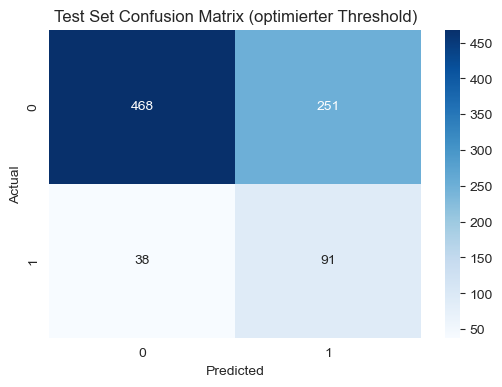

Optimal threshold saved to ../models/lasso_best_threshold.npy


In [3]:
# --- 03_lasso_regression_gridsearch_subsampling.ipynb ---

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.utils import resample
import shap
from sklearn.metrics import f1_score

# 1. Load preprocessed data
print("Loading train/test splits...")
X_train = np.load("../data/splits/X_train.npy")
y_train = np.load("../data/splits/y_train.npy")
X_test = np.load("../data/splits/X_test.npy")
y_test = np.load("../data/splits/y_test.npy")

# Convert numpy arrays back to pandas DataFrame
# Assuming the feature names are consistent
X_train_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
X_train = pd.DataFrame(X_train, columns=X_train_columns)
X_test = pd.DataFrame(X_test, columns=X_train_columns)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}\n")

# 2. Set up GridSearchCV for Lasso Logistic Regression
param_grid = {
    #'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5,
      0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5,
      4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0,
      25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0,
      70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 150.0,
      200.0, 250.0, 300.0, 400.0, 500.0],  # Expanded regularization strength values

    'penalty': ['l1'],             # L1 penalty for sparsity
    'solver': ['liblinear'],       # liblinear supports l1
}

# ==============================
# Part 1: Sub-sampling the Majority Class
# ==============================
print("Setting up Grid Search for Lasso Logistic Regression with sub-sampling...")

# Down-sample the majority class
X_minority = X_train[y_train == 1]
y_minority = y_train[y_train == 1]

X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]

# Down-sample majority class to match minority class
X_majority_downsampled, y_majority_downsampled = resample(X_majority, y_majority,
                                                          replace=False,
                                                          n_samples=len(X_minority),
                                                          random_state=42)

# Combine minority class with downsampled majority class
X_resampled = np.vstack((X_majority_downsampled, X_minority))
y_resampled = np.hstack((y_majority_downsampled, y_minority))

# Run GridSearchCV on the resampled data
print("Running Grid Search with sub-sampling...")
grid_search_subsampling = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    scoring='f1',  # Optimize for F1-Score (important for imbalanced data)
    cv=5,          # 5-fold cross-validation
    verbose=2,
    n_jobs=-1      # Use all cores for parallel processing
)

grid_search_subsampling.fit(X_resampled, y_resampled)

print("\nBest Parameters (sub-sampling):")
print(grid_search_subsampling.best_params_)
print(f"Best Cross-Validated F1-Score: {grid_search_subsampling.best_score_:.4f}\n")

# --- 03_lasso_regression_gridsearch_subsampling_with_threshold.py ---

# (vorheriger Code bleibt identisch bis einschließlich Modelltraining)

from sklearn.metrics import f1_score  # ergänzen, falls nicht importiert

# === 3. Evaluate with default threshold (0.5) ===
print("Test Set Results (threshold = 0.5):")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_subsampling):.4f}")
print("Classification Report (threshold = 0.5):")
print(classification_report(y_test, y_test_pred_subsampling))

# === 4. Threshold Optimization ===
print("\n🔍 Optimizing threshold for best F1 score...")

# 1. Predict probabilities
y_probs = best_model_subsampling.predict_proba(X_test)[:, 1]

# 2. Evaluate F1 for multiple thresholds
thresholds = np.linspace(0, 1, 200)
f1_scores = [f1_score(y_test, (y_probs >= t).astype(int)) for t in thresholds]

# 3. Select best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"✅ Optimaler Threshold: {best_threshold:.2f}")
print(f"✅ F1-Score bei optimalem Threshold: {best_f1:.4f}")

# 4. Plot
plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("F1-Score vs Threshold")
plt.grid(True)
plt.show()

# 5. Predict with optimal threshold
y_test_pred_opt = (y_probs >= best_threshold).astype(int)

print("\nTest Set Results (optimierter Threshold):")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_opt):.4f}")
print("Classification Report (optimierter Threshold):")
print(classification_report(y_test, y_test_pred_opt))

# 6. Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred_opt), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix (optimierter Threshold)")
plt.show()

# Optional: Save threshold
np.save("../models/lasso_best_threshold.npy", best_threshold)
print(f"Optimal threshold saved to ../models/lasso_best_threshold.npy")
